<a href="https://colab.research.google.com/github/Vikasbilla1953/Bank-Management-System/blob/main/major_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import all the libraries :**

In [ ]:
!pip install bs4

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=49d014872cabd0561b21520aa55326ca6c28ed8a523810c6aebfdbd5e1e19c94
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [ ]:
!pip install opendatasets

In [ ]:
import os
import re
import cv2
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
sns.set_style("whitegrid")
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')
import xml.etree.ElementTree as ET
from wordcloud import WordCloud, ImageColorGenerator

In [ ]:
import opendatasets
# kaggle datasets download -d lohith01/nlmcxrpngdataset

# opendatasets.download("https://www.kaggle.com/datasets/lohith01/nlmcxrpngdataset/versions/1/data")
opendatasets.download("https://www.kaggle.com/datasets/raddar/chest-xrays-indiana-university/")
# {"username":"lohith01","key":"35b9c853052556fc074a48808bff9b23"}

Skipping, found downloaded files in "./chest-xrays-indiana-university" (use force=True to force download)


In [ ]:
cwd = os.getcwd()

In [ ]:
# !wget https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz
# !wget https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz

In [ ]:
import tarfile
images = tarfile.open('./nlmcxrpngdataset/NLMCXR_png.tgz')
images.extractall(cwd+'/xray_images/')

In [ ]:
xml = tarfile.open('./nlmcxrpngdataset/NLMCXR_reports.tgz')
xml.extractall(cwd+'/xray_reports/')

**Display an XML :**

In [ ]:
with open("./xray_reports/ecgen-radiology/1.xml", 'r') as f:
    print(f.read())

<?xml version="1.0" encoding="utf-8"?>
<eCitation>
   <meta type="rr"/>
   <uId id="CXR1"/>
   <pmcId id="1"/>
   <docSource>CXR</docSource>
   <IUXRId id="1"/>
   <licenseType>open-access</licenseType>
   <licenseURL>http://creativecommons.org/licenses/by-nc-nd/4.0/</licenseURL>
   <ccLicense>byncnd</ccLicense>
   <articleURL/>
   <articleDate>2013-08-01</articleDate>
   <articleType>XR</articleType>
   <publisher>Indiana University</publisher>
   <title>Indiana University Chest X-ray Collection</title>
   <note>The data are drawn from multiple hospital systems.</note>
   <specialty>pulmonary diseases</specialty>
   <subset>CXR</subset>
   <MedlineCitation Owner="Indiana University" Status="supplied by publisher">
   
      <Article PubModel="Electronic">
      
         <Journal>
         
            <JournalIssue>
            
               <PubDate>
               
                  <Year>2013</Year>
               
                  <Month>08</Month>
               
            

**Checking the data stats :**

In [ ]:
print('Total Images in data : ', len(os.listdir('./xray_images')))
print('Total Reports in data : ', len(os.listdir('./xray_reports/ecgen-radiology')))

Total Images in data :  7471
Total Reports in data :  3955


In [ ]:
#list of count of images
img_count = []
for file in os.listdir('./xray_reports/ecgen-radiology'):
  xml_file = os.path.join('./xray_reports/ecgen-radiology',file)
  #reading the xml data
  with open(xml_file, 'r') as f:
    data = f.read()
  #getting all the image names
  regex = r"parentImage id.*"
  k  = re.findall(regex,data)
  temp = len(k)
  img_count.append(temp)

print("The max number of images associated with a report:",np.array(img_count).max())
print("The min number of images associated with a report:",np.array(img_count).min())

The max number of images associated with a report: 5
The min number of images associated with a report: 0


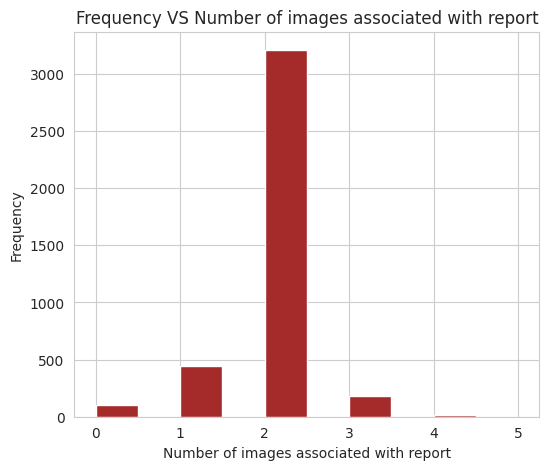

In [ ]:
plt.figure(figsize = (6,5))
ax = pd.Series(img_count).plot(kind='hist',color='brown')
ax.set_xlabel('Number of images associated with report')
ax.set_title("Frequency VS Number of images associated with report")
plt.show()

In [ ]:
print("Images per patient :\n")
print(pd.Series(img_count).value_counts())

Images per patient :

2    3208
1     446
3     181
0     104
4      15
5       1
dtype: int64


In [ ]:
#Reference : https://stackoverflow.com/questions/2723015/how-to-find-recursively-for-a-tag-of-xml-using-lxml

columns = ["image_name", "image_caption", "comparison", "indication", "findings", "impression"]
dataframe = pd.DataFrame(columns = columns)
for file in tqdm(os.listdir('./xray_reports/ecgen-radiology/')):
    #find files with .xml extension only
    if file.endswith(".xml"):
        # finding root element
        tree = ET.parse('./xray_reports/ecgen-radiology/'+file)#parse the xml file

        findings = tree.find(".//AbstractText[@Label='FINDINGS']").text
        indication = tree.find(".//AbstractText[@Label='INDICATION']").text
        comparision = tree.find(".//AbstractText[@Label='COMPARISON']").text
        impression = tree.find(".//AbstractText[@Label='IMPRESSION']").text

        caption = set()
        name_img = set()
        #find images in each parentImage tag
        for iterator in tree.findall("parentImage"):
            img = iterator.attrib['id']+".png"
            name_img.add(img)
            #add the corresponding report for each image
            caption.add('' if iterator.find('caption').text is None else iterator.find('caption').text)

        # add image details and reports to dataframe
        dataframe = dataframe.append(pd.Series([','.join(name_img), ','.join(caption), comparision, indication, findings, impression],
                                                         index = columns), ignore_index = True)


100%|██████████| 3955/3955 [00:04<00:00, 833.99it/s]


In [ ]:
dataframe.head()

image_name  \
0  CXR2219_IM-0823-1001.png,CXR2219_IM-0823-2001.png   
1  CXR2607_IM-1097-3003.png,CXR2607_IM-1097-2002.png   
2  CXR2671_IM-1148-1001-0001.png,CXR2671_IM-1148-...   
3  CXR3203_IM-1513-2001.png,CXR3203_IM-1513-1001.png   
4  CXR2449_IM-0984-1001.png,CXR2449_IM-0984-2001.png   

                             image_caption                   comparison  \
0  2 VIEW CHEST: XXXX, XXXX at XXXX hours.                         None   
1                Xray Chest PA and Lateral  No comparison chest x-XXXX.   
2                             Chest x-XXXX                         XXXX   
3                Xray Chest PA and Lateral                        None.   
4                     Chest X-XXXX 2 XXXX                          XXXX   

                                      indication  \
0  XXXX and chest pain commissure breath x1 XXXX   
1                         786.2, 30yof with XXXX   
2                                       Weakness   
3                               XXXX and dyspnea   
4                                        Dyspnea   

                                            findings  \
0                                               None   
1                                               None   
2                                               None   
3  Cardiac and mediastinal contours are within no...   
4  The lungs are clear. The cardiomediastinal sil...   

                                          impression  
0  The heart size and cardiomediastinal silhouett...  
1  Lungs appear hyperinflated. This may be second...  
2  PA and lateral views were obtained. Again, a c...  
3                                 No acute findings.  
4                                   Negative chest .

In [ ]:
# Shape of the DataFrame
print('Shape of the Dataframe : ', dataframe.shape)

Shape of the Dataframe :  (3955, 6)


In [ ]:
data2 =pd.read_excel("radiology_vocabulary_final.xlsx")

In [ ]:
data2 = data2.fillna(0)
from numpy import NAN
# Iterate row-wise through the DataFrame
dict2={}
for index, row in data2.iterrows():
    # 'index' is the row index
    # 'row' is a pandas Series containing the row data
    c=row[0]
    i=0
    for d in row :
      if i<3:
        i+=1
        continue
      if(d!=0 and d!=c):
        dict2[d]=c

for key in dict2.keys():
  print(key,":",dict2[key])
print(len(dict2))

adiposis; localized : Adipose Tissue
fatty tissue hyperplasia : Adipose Tissue
localized fat : Adipose Tissue
lipohyperplasia : Adipose Tissue
localised adiposity : Adipose Tissue
localised obesity : Adipose Tissue
fat pads : Adipose Tissue
aortic : Aorta
aortic structure : Aorta
thoracic aorta : Aorta, Thoracic
apical : Apex
basilar : Base
basal : Base
bone : Bone and Bones 
bones : Bone and Bones 
skeleton : Bone and Bones 
skeletal : Bone and Bones 
bone tissue : Bone and Bones 
bronchial : Bronchi
bronchus : Bronchi
right main bronchus : Bronchi
left main bronchus : Bronchi
cardiophrenic sulcus  : Cardiophrenic Angle
cervical spine : Cervical Vertebrae
cervical spinal column : Cervical Vertebrae
cervical vertebral column : Cervical Vertebrae
c spine : Cervical Vertebrae
coronary arteries : Coronary Vessels
coronary veins : Coronary Vessels
costophrenic recess : Costophrenic Angle
respiratory diaphragm : Diaphragm
hemidiaphragms : Diaphragm
hemidiaphragm : Diaphragm
atrium : Heart A

In [ ]:
print((dataframe['findings'][3]))

Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact.


In [ ]:
len(dataframe["findings"])

3955

In [ ]:
c=0
for i in range(len(dataframe["findings"])):
  line2=dataframe.loc[i,"findings"]
  line = dataframe.loc[i,"findings"]
  if line != None:
    line = str(line)
    for key in dict2.keys():
      if line.find(key):
        c+=1
        line.replace(key,dict2[key])
    print(c," ",line2)
    print(line)
    print()
    dataframe.loc[i,"findings"] = line

print(c)

Streaming output truncated to the last 5000 lines.

665280   Lungs are relatively clear. Heart size normal. Unfolded aorta. Moderate hiatal hernia. T-spine osteophytes and DISH.
Lungs are relatively clear. Heart size normal. Unfolded aorta. Moderate hiatal hernia. T-spine osteophytes and DISH.

665658   The heart is not enlarged. The bilateral pulmonary arteries appear enlarged. The lungs are hyperexpanded the hemidiaphragms are flattened. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation.
The heart is not enlarged. The bilateral pulmonary arteries appear enlarged. The lungs are hyperexpanded the hemidiaphragms are flattened. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation.

666036   Heart size and mediastinal contours appear within normal limits. Pulmonary vascularity is within normal limits. No focal consolidation, suspicious pulmonary opacity, pneumothorax or definite pleural effusion. Visualized osseous s

In [ ]:
dataframe.head()

image_name  \
0  CXR2219_IM-0823-1001.png,CXR2219_IM-0823-2001.png   
1  CXR2607_IM-1097-3003.png,CXR2607_IM-1097-2002.png   
2  CXR2671_IM-1148-1001-0001.png,CXR2671_IM-1148-...   
3  CXR3203_IM-1513-2001.png,CXR3203_IM-1513-1001.png   
4  CXR2449_IM-0984-1001.png,CXR2449_IM-0984-2001.png   

                             image_caption                   comparison  \
0  2 VIEW CHEST: XXXX, XXXX at XXXX hours.                         None   
1                Xray Chest PA and Lateral  No comparison chest x-XXXX.   
2                             Chest x-XXXX                         XXXX   
3                Xray Chest PA and Lateral                        None.   
4                     Chest X-XXXX 2 XXXX                          XXXX   

                                      indication  \
0  XXXX and chest pain commissure breath x1 XXXX   
1                         786.2, 30yof with XXXX   
2                                       Weakness   
3                               XXXX and dyspnea   
4                                        Dyspnea   

                                            findings  \
0                                               None   
1                                               None   
2                                               None   
3  Cardiac and mediastinal contours are within no...   
4  The lungs are clear. The cardiomediastinal sil...   

                                          impression  
0  The heart size and cardiomediastinal silhouett...  
1  Lungs appear hyperinflated. This may be second...  
2  PA and lateral views were obtained. Again, a c...  
3                                 No acute findings.  
4                                   Negative chest .

In [ ]:
type(dataframe['findings'][0])

NoneType

**Preprocessing :**

In [ ]:
# function for obtaining the different information part of the xml report file and preprocessing them and also adding the concernced image and report information to the dataframe
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


In [ ]:
def preprocess_text(data): #https://regex101.com/
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  preprocessed = []

  for sentence in tqdm(data.values):

    sentence = BeautifulSoup(sentence, 'lxml').get_text()

    regex = r"\d."
    sentence = re.sub(regex,"",sentence) #removing all values like "1." and "2." etc

    regex = r"X+"
    sentence = re.sub(regex,"",sentence) #removing words like XXXX

    regex = r"[^.a-zA-Z]"
    sentence = re.sub(regex," ",sentence) #removing all special characters except for full stop

    regex = r"http\S+"
    sentence = re.sub(regex,"", sentence)
    sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?$%^&*'/+\[\]_]+", "", sentence)
    sentence = re.sub('&', 'and',sentence)
    sentence = re.sub('@', 'at',sentence)
    sentence = re.sub('0', 'zero',sentence)
    sentence = re.sub('1', 'one',sentence)
    sentence = re.sub('2', 'two',sentence)
    sentence = re.sub('3', 'three',sentence)
    sentence = re.sub('4', 'four',sentence)
    sentence = re.sub('5', 'five',sentence)
    sentence = re.sub('6', 'six',sentence)
    sentence = re.sub('7', 'seven',sentence)
    sentence = re.sub('8', 'eight',sentence)
    sentence = re.sub('9', 'nine',sentence)
    sentence = re.sub('year old', "", sentence)#Occur multiple times in Indication feature but not necessary
    sentence = re.sub('yearold', "", sentence)
    sentence = decontracted(sentence) #perform decontraction
    sentence = sentence.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
    sentence = " ".join(sentence.split()) #removes unwanted spaces
    if sentence=="": #if the resulting sentence is an empty string return null value
      sentence = np.nan
    preprocessed.append(sentence)
  return preprocessed

In [ ]:
#Check for Null values in Text columns
NaN = dataframe.isnull().sum()
print("Total Nan Values in caption columns -",NaN[1])
print("Total Nan Values in comparison columns -",NaN[2])
print("Total Nan Values in Indication columns -",NaN[3])
print("Total Nan Values in findings columns   -",NaN[4])
print("Total Nan Values in Impression columns -",NaN[5])

Total Nan Values in caption columns - 0
Total Nan Values in comparison columns - 622
Total Nan Values in Indication columns - 90
Total Nan Values in findings columns   - 530
Total Nan Values in Impression columns - 34


In [ ]:
#Replacing the nan values
dataframe['image_caption'] = dataframe['image_caption'].fillna('Unknown')
dataframe['comparison'] = dataframe['comparison'].fillna('No Comparison')
dataframe['indication'] = dataframe['indication'].fillna('No Indication')
dataframe['findings'] = dataframe['findings'].fillna('No Findings')
dataframe['impression'] = dataframe['impression'].fillna('No Impression')

In [ ]:
#Check for Null values in Text columns
NaN = dataframe.isnull().sum()
print("Total Nan Values in caption columns -",NaN[1])
print("Total Nan Values in comparison columns -",NaN[2])
print("Total Nan Values in Indication columns -",NaN[3])
print("Total Nan Values in findings columns   -",NaN[4])
print("Total Nan Values in Impression columns -",NaN[5])

Total Nan Values in caption columns - 0
Total Nan Values in comparison columns - 0
Total Nan Values in Indication columns - 0
Total Nan Values in findings columns   - 0
Total Nan Values in Impression columns - 0


In [ ]:
#Preprocessing of text features
dataframe['image_caption'] = preprocess_text(dataframe['image_caption'])
dataframe['comparison'] = preprocess_text(dataframe['comparison'])
dataframe['indication'] = preprocess_text(dataframe['indication'])
dataframe['findings'] = preprocess_text(dataframe['findings'])
dataframe['impression'] = preprocess_text(dataframe['impression'])

100%|██████████| 3955/3955 [00:00<00:00, 5072.30it/s]


In [ ]:
dataframe.replace("", float("NaN"), inplace=True)

In [ ]:
#percentage missing values
print(dataframe.isnull().sum()*100/dataframe.shape[0] )

image_name        2.629583
image_caption     2.680152
comparison       20.960809
indication        5.638432
findings          0.025284
impression        0.000000
dtype: float64


In [ ]:
dataframe.dropna(subset = ["image_name"], inplace=True)
dataframe.shape

(3851, 6)

In [ ]:
dataframe.head()

image_name  \
0  CXR2219_IM-0823-1001.png,CXR2219_IM-0823-2001.png   
1  CXR2607_IM-1097-3003.png,CXR2607_IM-1097-2002.png   
2  CXR2671_IM-1148-1001-0001.png,CXR2671_IM-1148-...   
3  CXR3203_IM-1513-2001.png,CXR3203_IM-1513-1001.png   
4  CXR2449_IM-0984-1001.png,CXR2449_IM-0984-2001.png   

              image_caption             comparison  \
0       view chest at hours                   none   
1  ray chest pa and lateral  no comparison chest x   
2                   chest x                    NaN   
3  ray chest pa and lateral                   none   
4                     chest                    NaN   

                           indication  \
0  and chest pain commissure breath x   
1                            yof with   
2                            weakness   
3                         and dyspnea   
4                             dyspnea   

                                            findings  \
0                                        no findings   
1                                        no findings   
2                                        no findings   
3  cardiac and mediastinal contours are within no...   
4  the lungs are clear the cardiomediastinal silh...   

                                          impression  
0  the heart size and cardiomediastinal silhouett...  
1  lungs appear hyperinflated this may be seconda...  
2  pa and lateral views were obtained again a chr...  
3                                  no acute findings  
4                                     negative chest

In [ ]:
vocabulary = {}
for i in dataframe["findings"]:
  i = str(i)
  words = i.split(" ")
  for j in words:
    if j in vocabulary:
      vocabulary[j]+=1
    else:
      vocabulary[j]=1

print(len(vocabulary))

1582


In [ ]:
doc_freq={}
for i in vocabulary:
  for j in dataframe['findings']:
    j = str(j)
    words = j.split(" ")
    if i in words:
      if i in doc_freq:
        doc_freq[i]+=1
      else:
        doc_freq[i]=1

print(doc_freq)

{'no': 3199, 'findings': 714, 'cardiac': 387, 'and': 1974, 'mediastinal': 820, 'contours': 531, 'are': 2403, 'within': 1351, 'normal': 2814, 'limits': 1331, 'the': 2522, 'lungs': 1835, 'clear': 1444, 'bony': 512, 'structures': 563, 'intact': 364, 'cardiomediastinal': 791, 'silhouette': 948, 'is': 2161, 'pneumothorax': 2365, 'or': 2219, 'pleural': 2389, 'effusion': 2192, 'again': 80, 'seen': 392, 'paraspinal': 3, 'foreign': 12, 'body': 49, 'which': 105, 'may': 92, 'represent': 65, 'a': 428, 'bullet': 5, 'fragment': 5, 'frontal': 103, 'lateral': 267, 'views': 76, 'of': 1565, 'chest': 267, 'show': 83, 'size': 1878, 'configuration': 48, 'contour': 508, 'pulmonary': 1092, 'vasculature': 289, 'central': 97, 'airways': 24, 'lung': 567, 'volumes': 225, 'scattered': 66, 'calcified': 361, 'granulomas': 88, 'left': 624, 'greater': 33, 'than': 43, 'right': 705, 'basilar': 76, 'opacity': 371, 'probable': 16, 'atelectasis': 220, 'scarring': 141, 'bilaterally': 240, 'silhouettes': 65, 'acute': 652, '

In [ ]:
max_ni=0
for key,value in doc_freq.items():
  max_ni=max(max_ni,value)

In [ ]:
import math
N=len(dataframe['findings'])

matrix_inv_freq_max=[]
for i in vocabulary:
  temp1=[]
  for j in dataframe['findings']:
    j = str(j)
    words = j.split(" ")
    count=0
    for k in words:
      if k == i:
        count+=1
    if count!=0:
      temp1.append((1+math.log2(count))*math.log2(1+(max_ni/doc_freq[i])))
    else:
      temp1.append(0)
  matrix_inv_freq_max.append(temp1)

In [ ]:
print(matrix_inv_freq_max[:5])

[[1.0, 1.0, 1.0, 0, 1.0, 1.0, 2.0, 1.0, 2.584962500721156, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 2.584962500721156, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0, 1.0, 0, 3.0, 0, 1.0, 1.0, 0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 0, 2.0, 2.0, 0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 2.0, 2.584962500721156, 1.0, 1.0, 0, 2.0, 0, 3.0, 0, 1.0, 2.0, 2.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 2.584962500721156, 2.0, 0, 0, 2.0, 0, 0, 0, 2.0, 1.0, 2.0, 1.0, 2.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 2.0, 2.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 3.0, 2.0, 0, 1.0, 0, 1.0, 1.0, 2.0, 2.0, 1.0, 0, 2.0, 1.0, 0, 1.0, 1.0, 2.584962500721156, 1.0, 2.0, 2.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 2.584962500721156, 1.0, 2.0, 0, 1.0, 1.0, 2.0, 0, 1.0, 1.0, 1.0, 

In [ ]:
matrix_inv_freq_max = np.array(matrix_inv_freq_max)

In [ ]:
matrix_inv_freq_max.shape

(1582, 3851)

**Add Image count feature :**

In [ ]:
dataframe['image_count'] = dataframe['image_name'].astype(str).str.split(',').apply(len)

**Adding word count feature for indication, findings and impression :**


In [ ]:
#Adding word count feature for indication, findings and impression
dataframe['indication_count'] = dataframe['indication'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
dataframe['findings_count'] = dataframe['findings'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
dataframe['impression_count'] = dataframe['impression'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
dataframe.head()

image_name  \
0  CXR2219_IM-0823-1001.png,CXR2219_IM-0823-2001.png   
1  CXR2607_IM-1097-3003.png,CXR2607_IM-1097-2002.png   
2  CXR2671_IM-1148-1001-0001.png,CXR2671_IM-1148-...   
3  CXR3203_IM-1513-2001.png,CXR3203_IM-1513-1001.png   
4  CXR2449_IM-0984-1001.png,CXR2449_IM-0984-2001.png   

              image_caption             comparison  \
0       view chest at hours                   none   
1  ray chest pa and lateral  no comparison chest x   
2                   chest x                    NaN   
3  ray chest pa and lateral                   none   
4                     chest                    NaN   

                           indication  \
0  and chest pain commissure breath x   
1                            yof with   
2                            weakness   
3                         and dyspnea   
4                             dyspnea   

                                            findings  \
0                                        no findings   
1                                        no findings   
2                                        no findings   
3  cardiac and mediastinal contours are within no...   
4  the lungs are clear the cardiomediastinal silh...   

                                          impression  image_count  \
0  the heart size and cardiomediastinal silhouett...            2   
1  lungs appear hyperinflated this may be seconda...            2   
2  pa and lateral views were obtained again a chr...            2   
3                                  no acute findings            2   
4                                     negative chest            2   

   indication_count  findings_count  impression_count  
0                 6               2                33  
1                 2               2                25  
2                 1               2                39  
3                 2              16                 3  
4                 1              28                 2

<h3>Exploring the Image features :</h3>

**Displaying sample 9 patient X-Ray :**

**Displaying Sample Images + Caption :**

In [ ]:
def show_image_captions(df,sample):
    '''This function prints the sample images and its other text features.
       Parameters :
       - df: dataframe
       - sample: Number of datapoints'''

    sampled_row = df.sample(sample)

    for count, row in sampled_row.iterrows():
        print("Caption :",row['image_caption'])
        imgs = row["image_name"].split(',')
        fig, axs = plt.subplots(1, len(imgs), figsize = (10,10), tight_layout=True)
        iterator = 0

        for img, figure in zip(imgs, axs.flat):
            image= mpimg.imread("./xray_images/"+img)
            imgplot = axs[iterator].imshow(image)
            iterator +=1

        plt.show()
        print("\nComparision :",row.get('comparision'))
        print("\nIndication :",row.get('indication'))
        print("\nFindings :",row.get('findings'))
        print("\nImpression :",row.get('impression'))
        print("="*100,'\n')

Caption : pa and lateral chest


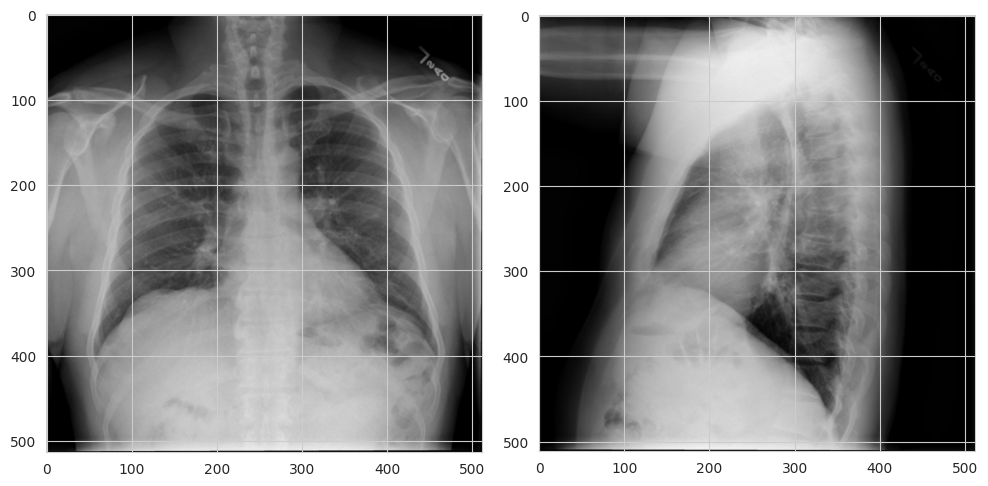


Comparision : None

Indication : with

Findings : heart size and mediastinal contours appear within normal limits eventration of the right hemidiaphragm no focal lung consolidation pleural effusion or pneumothorax no acute bony abnormality

Impression : no acute cardiopulmonary abnormality

Caption : pa and lateral chest radiograph


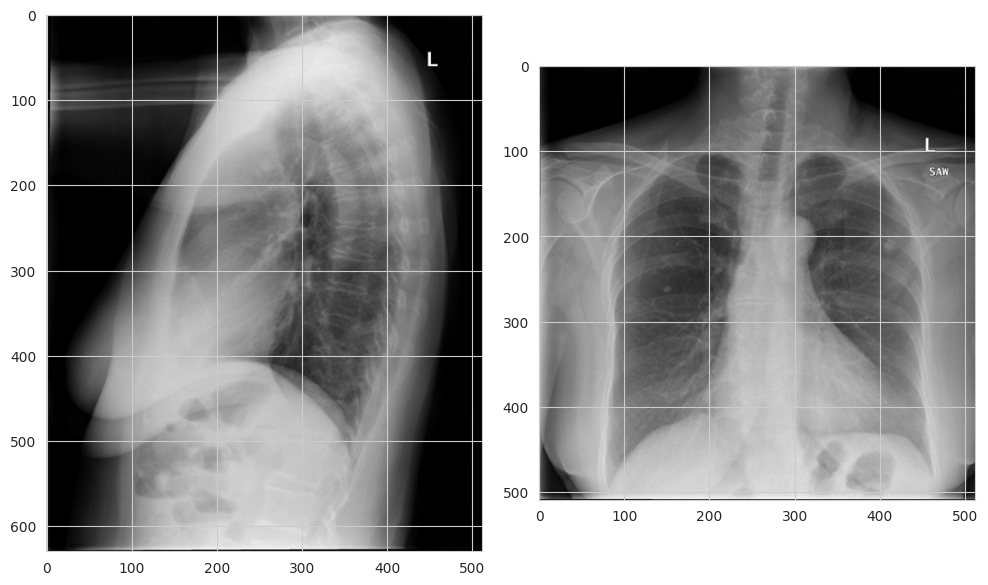


Comparision : None

Indication : nan

Findings : heart size and mediastinal contour within normal limits atherosclerotic calcification of the aorta stable scattered calcified granulomas are noted no focal airspace consolidation pneumothorax or large pleural effusion no acute osseous abnormality

Impression : no acute abnormality



In [ ]:
#showing sample 2 datapoints
show_image_captions(dataframe, 2)

**Observations :**

* Images are in different shapes.
* All the X-Ray images are human upper body particularly about Chest part.

<h3>Exploring the Text features :</h3>

**Note :** For text feature analysis, I will not consider the "Comparision" label/feature. The reason behind this is, comparision label has most of its values as 'none' and 'no comparision' (which I had put in place of missing values). So, this will be not much helpful to predict the Target.

In [ ]:
k = dataframe.loc[(dataframe.comparison == 'none') | (dataframe.comparison == 'no comparison')]
print("Number of rows with no informnation in comparision label:",k.shape[0])

Number of rows with no informnation in comparision label: 20


**Observation :** Out of 3851 rows in data, 2805 rows have No Information in comparision feature/label.

**Feature Identification : Text or Categorical ?**

**Note :** It seems all of the text features are just text features. We can't consider any of them as categorical. We can confirm that by finding unique values and analysing them. Because if it is categorical, then we could get better predictions compared to giving it as a text feature.


In [ ]:
def unique_words_features(df):
    '''This function takes pandas dataframe and show barplot of features unique and repeated words
       Input  =  pandas dataframe or numpy arrays
       Output =  barplot of the unique words of dataframe '''

    #length of the feature
    len_total = len(df.tolist())

    #length of unique words in the featue
    len_unique = len(np.unique(df.tolist()))

    x = ['Total Values', 'Unique Values']
    y =  [len_total, len_unique]

    plt.bar(x,y,color = 'Teal')
    plt.ylabel('Word-Count')
    for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))

    plt.ylabel('Word-Count')

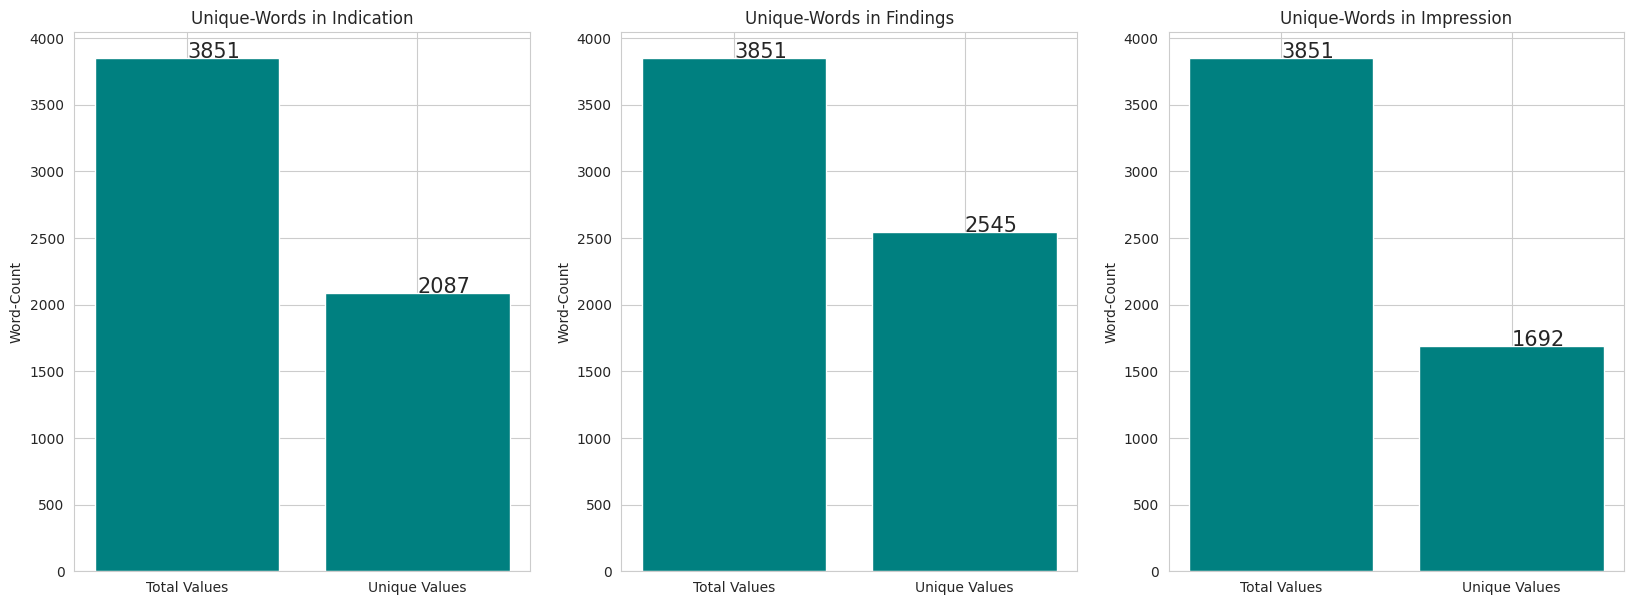

In [ ]:
plt.figure(figsize = (20,7))
plt.subplot(131)
unique_words_features(dataframe['indication'])
plt.title('Unique-Words in Indication')
plt.subplot(132)
unique_words_features(dataframe['findings'])
plt.title('Unique-Words in Findings')
plt.subplot(133)
unique_words_features(dataframe['impression'])
plt.title('Unique-Words in Impression')
plt.show()

**Observation :** We conclude from above features bar plot, That all of them are text features as there are total 3851 entries and and a good chunk of values are unique in all of them i.e, They never repeated. So, they can not be categorical features.

**Analysis of Indication feature :**

In [ ]:
#Printing min,max and median of word_count
print("Minimum number of word count for Indication is:",np.min(dataframe.indication_count.values))
print("Maximum number of word count for Indication is:",np.max(dataframe.indication_count.values))
print("median number of word count for Indication is:",np.median(dataframe.indication_count.values))

Minimum number of word count for Indication is: 1
Maximum number of word count for Indication is: 32
median number of word count for Indication is: 3.0


Plotting PDF and CDF for word_count distribution of Indication feature :

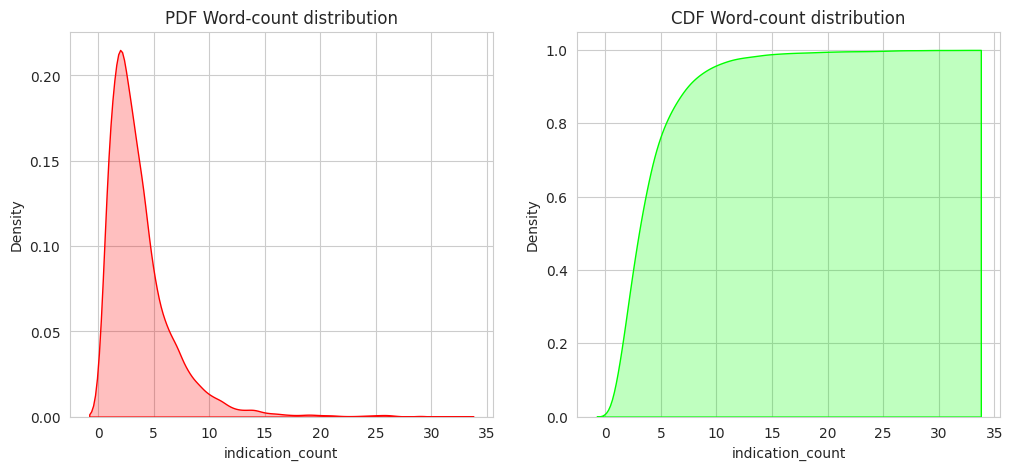

In [ ]:
#Plotting PDF and CDF for word_count distribution of Indication feature
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(dataframe['indication_count'],shade=True,color='Red')
plt.title("PDF Word-count distribution")
plt.subplot(122)
# Seaborn CDF
sns.distplot(dataframe['indication_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='Lime')
plt.title("CDF Word-count distribution")
plt.show()

Top 50 frequent sentences of Indication feature :

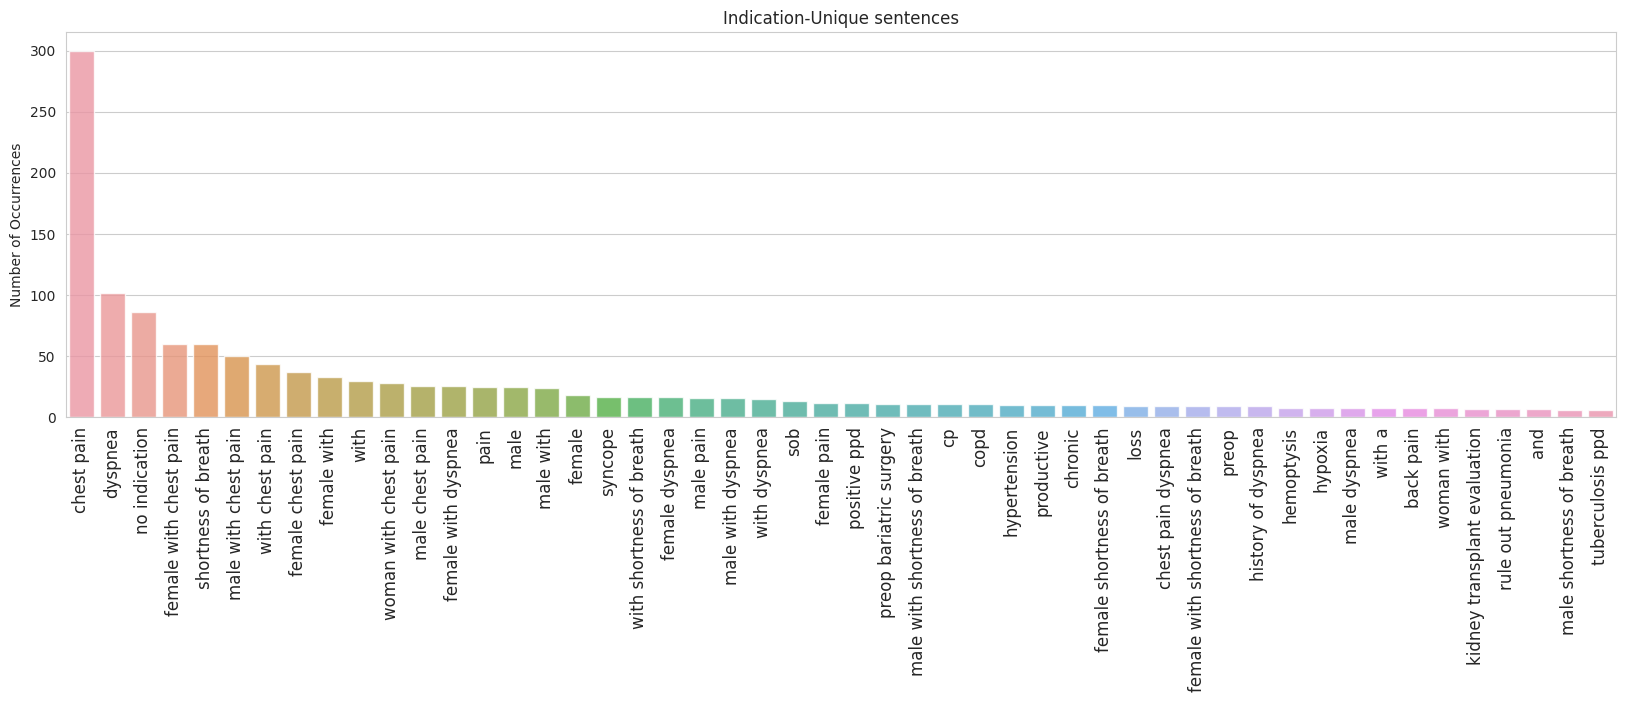

In [ ]:
#Plotting top 50 frequent sentences of Indication feature
sentences = dataframe['indication'].value_counts()[:50]
# print(sentences.values)
plt.figure(figsize=(20,5))
sns.barplot(x=sentences.index, y=sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("Indication-Unique sentences")
plt.show()

Word cloud on Indication feature : max 500 words

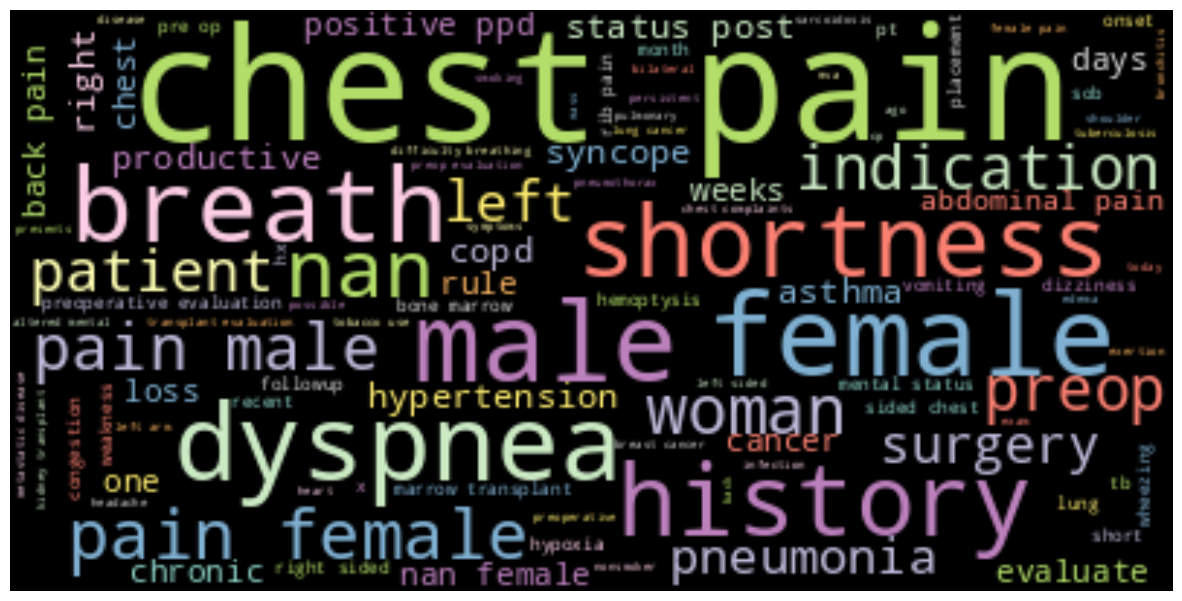

In [ ]:
wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(dataframe['indication'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

**Observations for Indication feature :**

* Top two most frequent words are 'no indication' and 'chest pain' above 300 counts in feature.
* In indication feature, 50% data have 7-8 words, 99% text data have less than 10 words in rows. Only 1% data have legnth above 10.
* From wordcloud : chest, pain, shortness, breath, indication are the highlighted words i.e. these are important words.

**Analysis of Findings feature :**

In [ ]:
#Printing min,max and median of word_count
print("Minimum number of word count for finding is:",np.min(dataframe.findings_count.values))
print("Maximum number of word count for finding is:",np.max(dataframe.findings_count.values))
print("Median number of word count for finding is:",np.median(dataframe.findings_count.values))

Minimum number of word count for finding is: 1
Maximum number of word count for finding is: 166
Median number of word count for finding is: 26.0


Plotting PDF and CDF for word_count distribution of Findings feature :

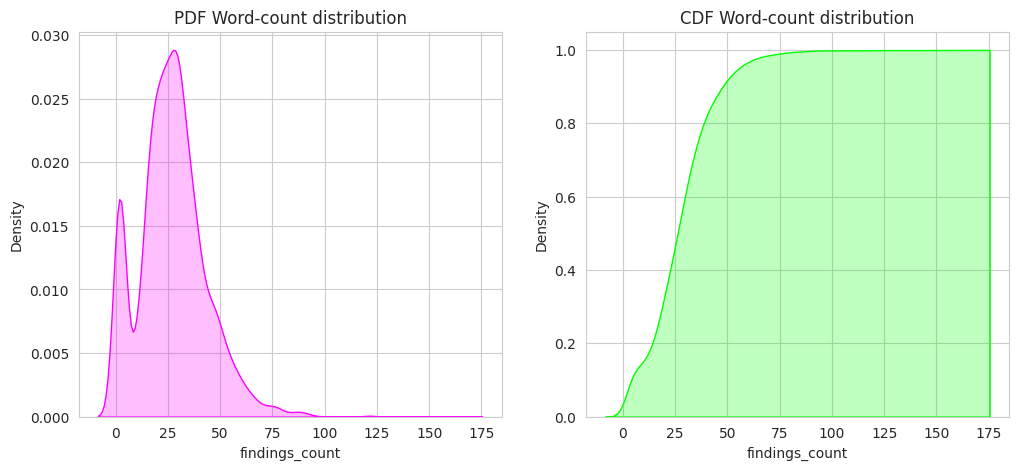

In [ ]:
#Plotting the PDF for word_count distribution of Findings feature
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(dataframe['findings_count'],shade=True,color='Magenta')
plt.title("PDF Word-count distribution")
plt.subplot(122)
# Seaborn CDF
sns.distplot(dataframe['findings_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='Lime')
plt.title("CDF Word-count distribution")
plt.show()

Top 50 frequent sentences of Findings feature :

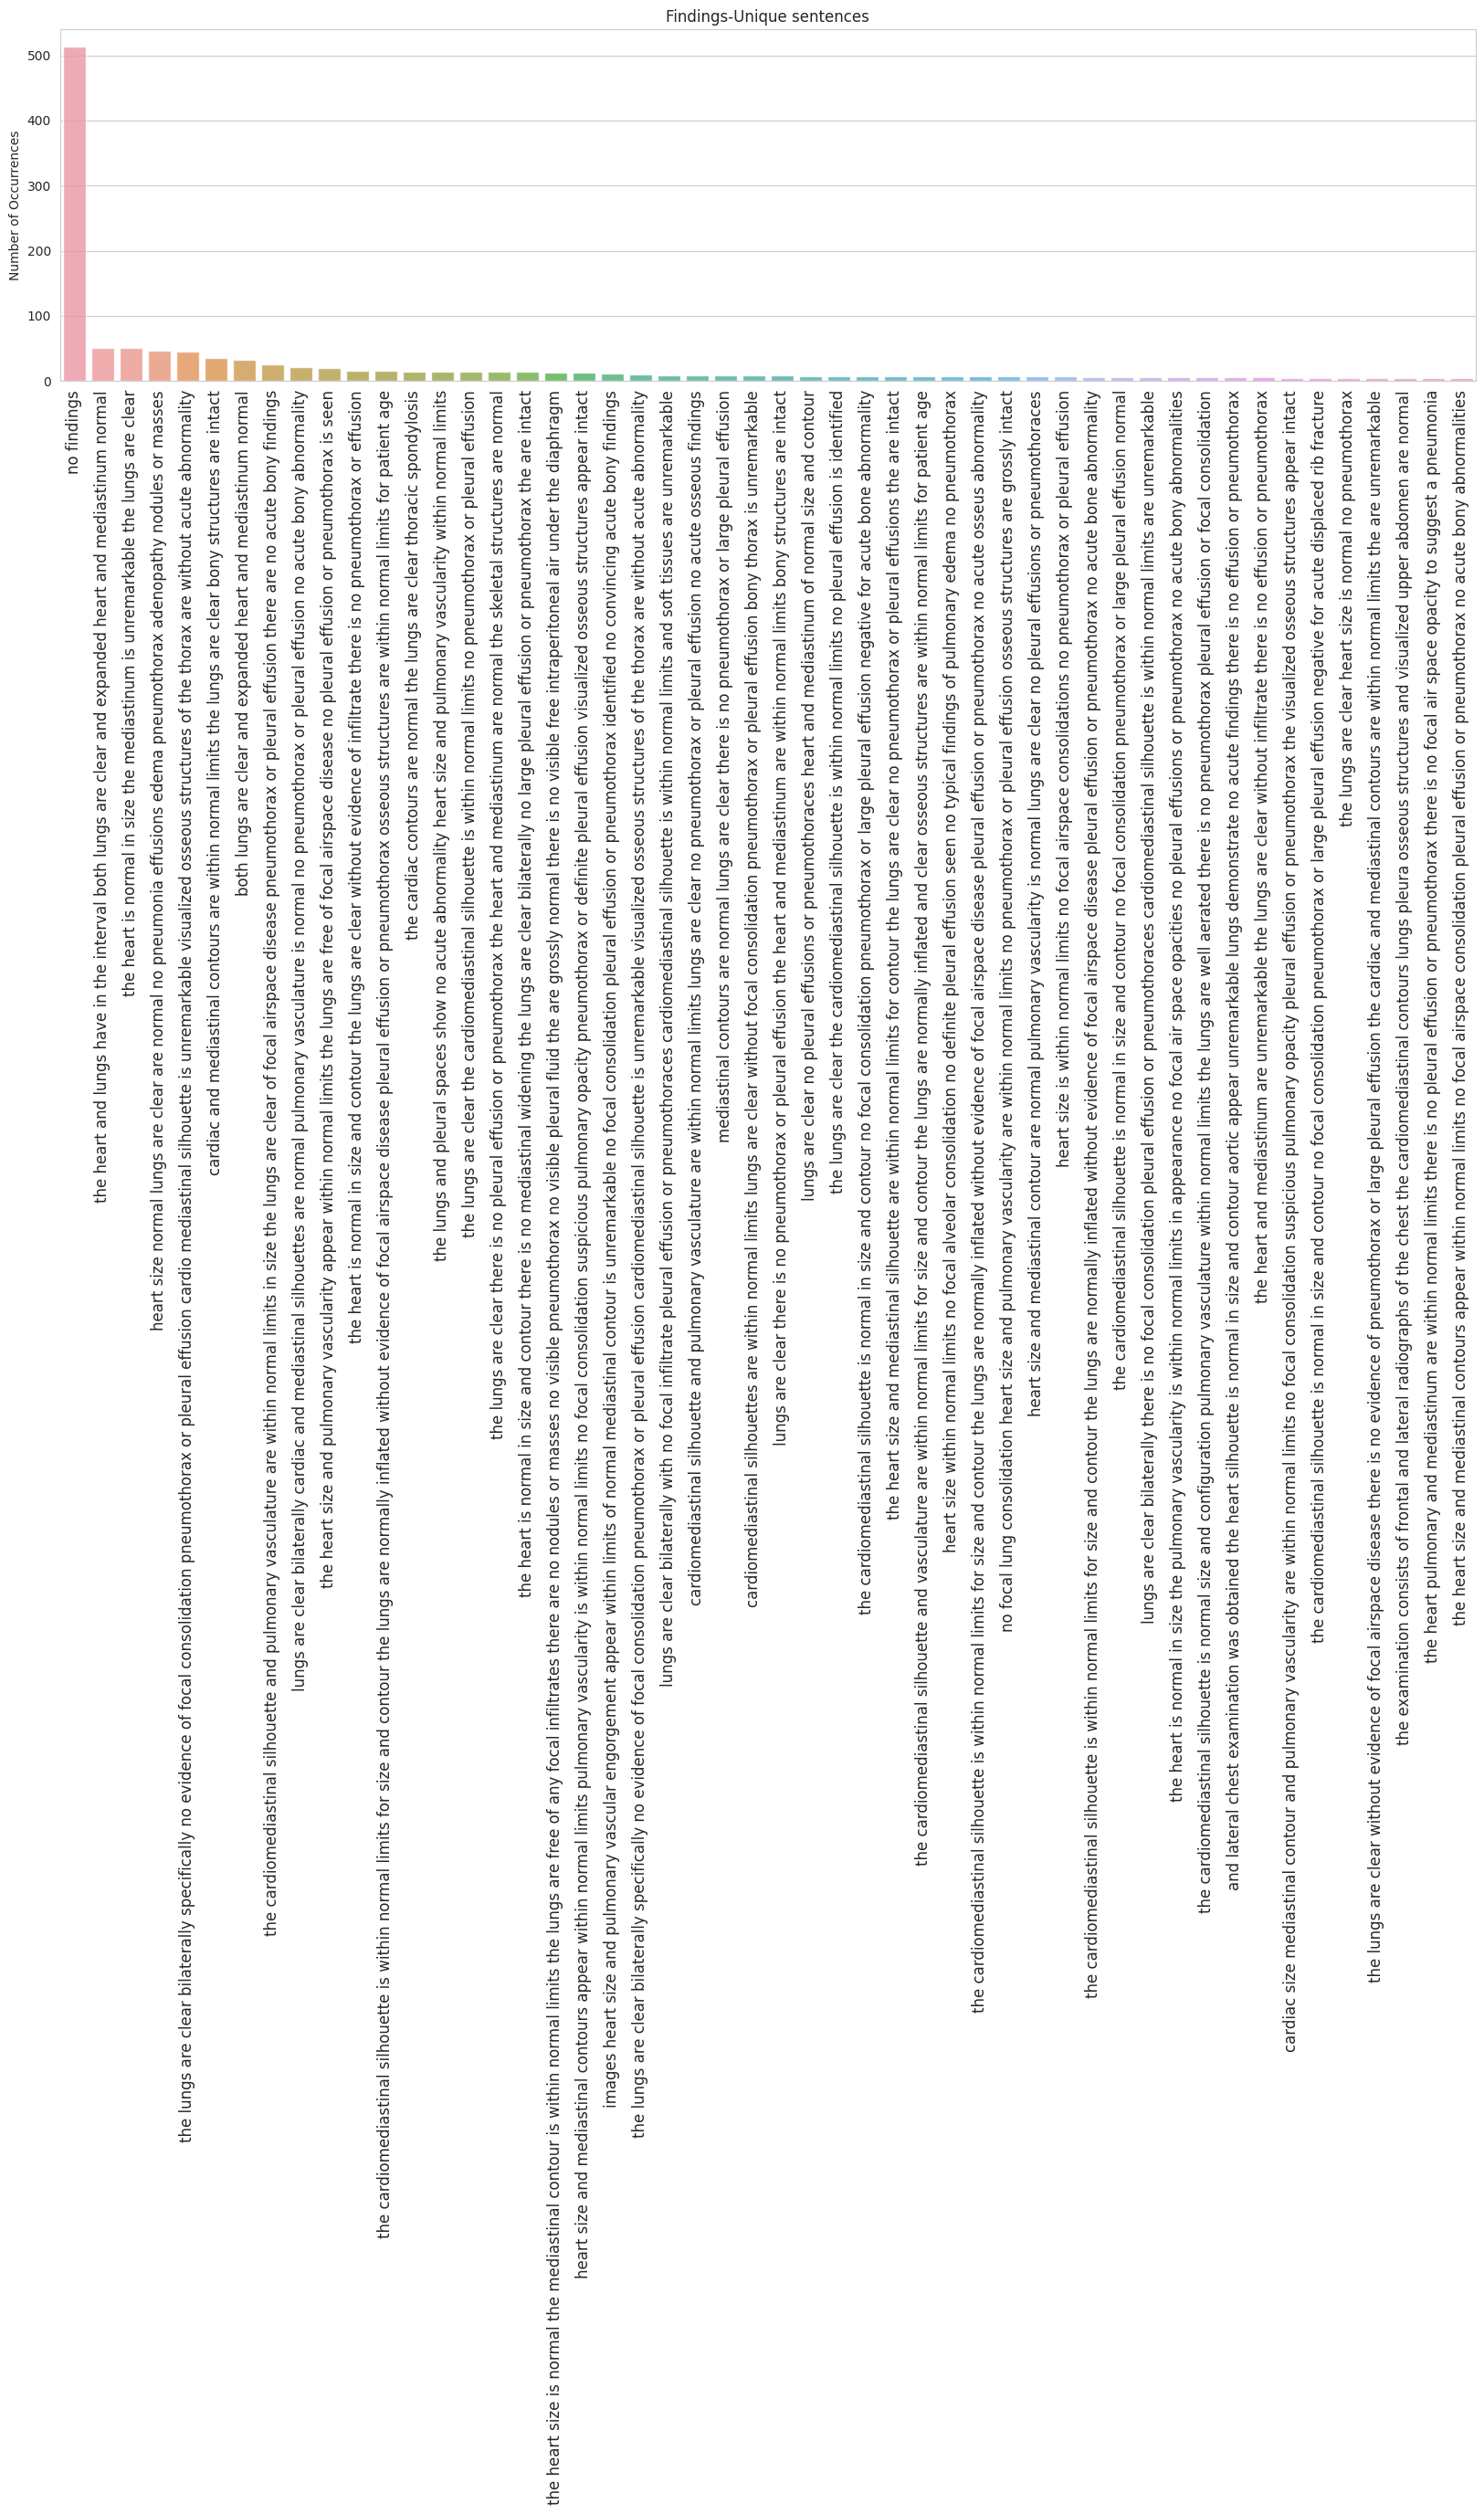

In [ ]:
#Plotting top 50 frequent sentences of Findings feature
sentences = dataframe['findings'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(x=sentences.index, y=sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("Findings-Unique sentences")
plt.show()

Word cloud on Findings feature : max 500 words

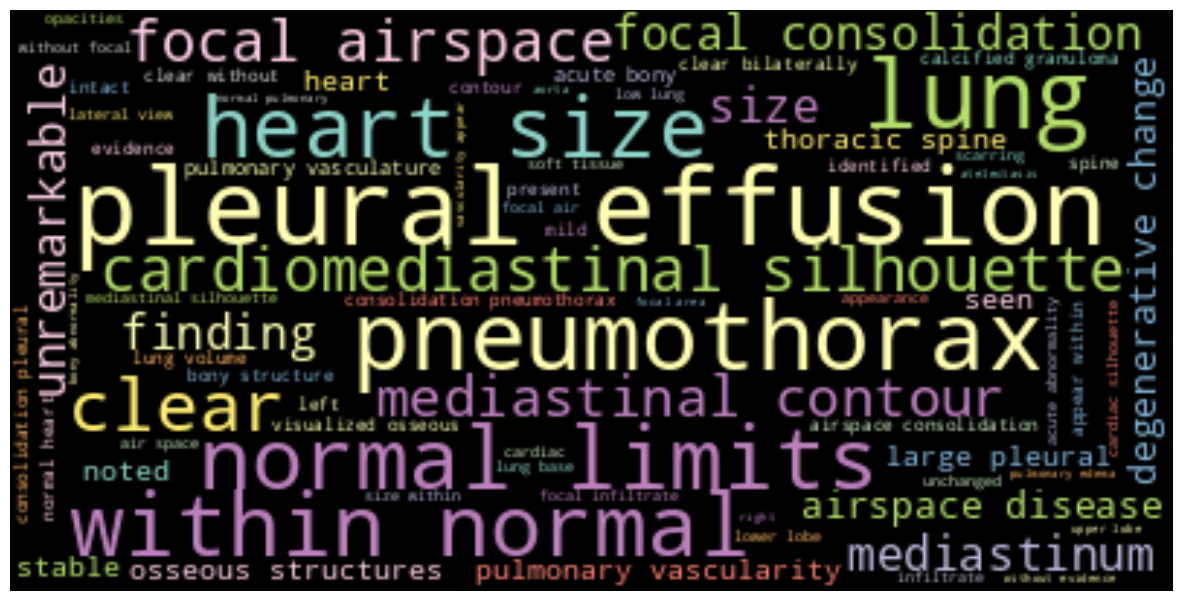

In [ ]:
wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(dataframe['findings'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

**Observations for Findings feature :**

* In finding feature, 50% data have less than 20 words per findings, 99% data have less than 48 words per findings. Only 1% data have legnth above 48.
* From wordcloud : pleural, effusion, silhouette, within, normal, lungs, cardiomediastinal are the highlighted words i.e. these are important words.

**Analysis of Target Feature : Impression**

In [ ]:
#Printing min,max and median of word_count
print("Minimum number of word count for Impression is:",np.min(dataframe.impression_count.values))
print("Maximum number of word count for Impression is:",np.max(dataframe.impression_count.values))
print("Median number of word count for Impression is:",np.median(dataframe.impression_count.values))

Minimum number of word count for Impression is: 1
Maximum number of word count for Impression is: 123
Median number of word count for Impression is: 5.0


Plotting PDF and CDF for word_count distribution of Impression feature :

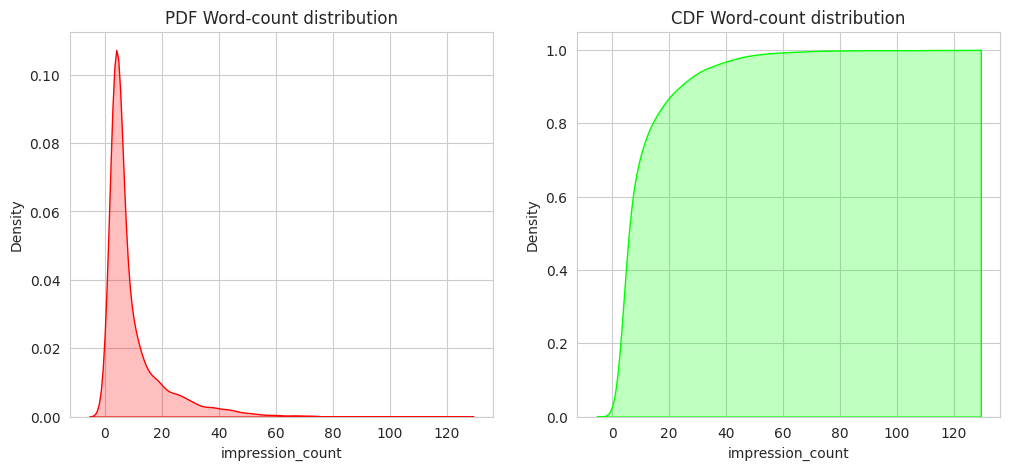

In [ ]:
#Plotting PDF and CDF for word_count distribution of Impression feature
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(dataframe['impression_count'],shade=True,color='Red')
plt.title("PDF Word-count distribution")
plt.subplot(122)
# Seaborn CDF
sns.distplot(dataframe['impression_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='Lime')
plt.title("CDF Word-count distribution")
plt.show()

Top 50 frequent sentences of Impression feature :

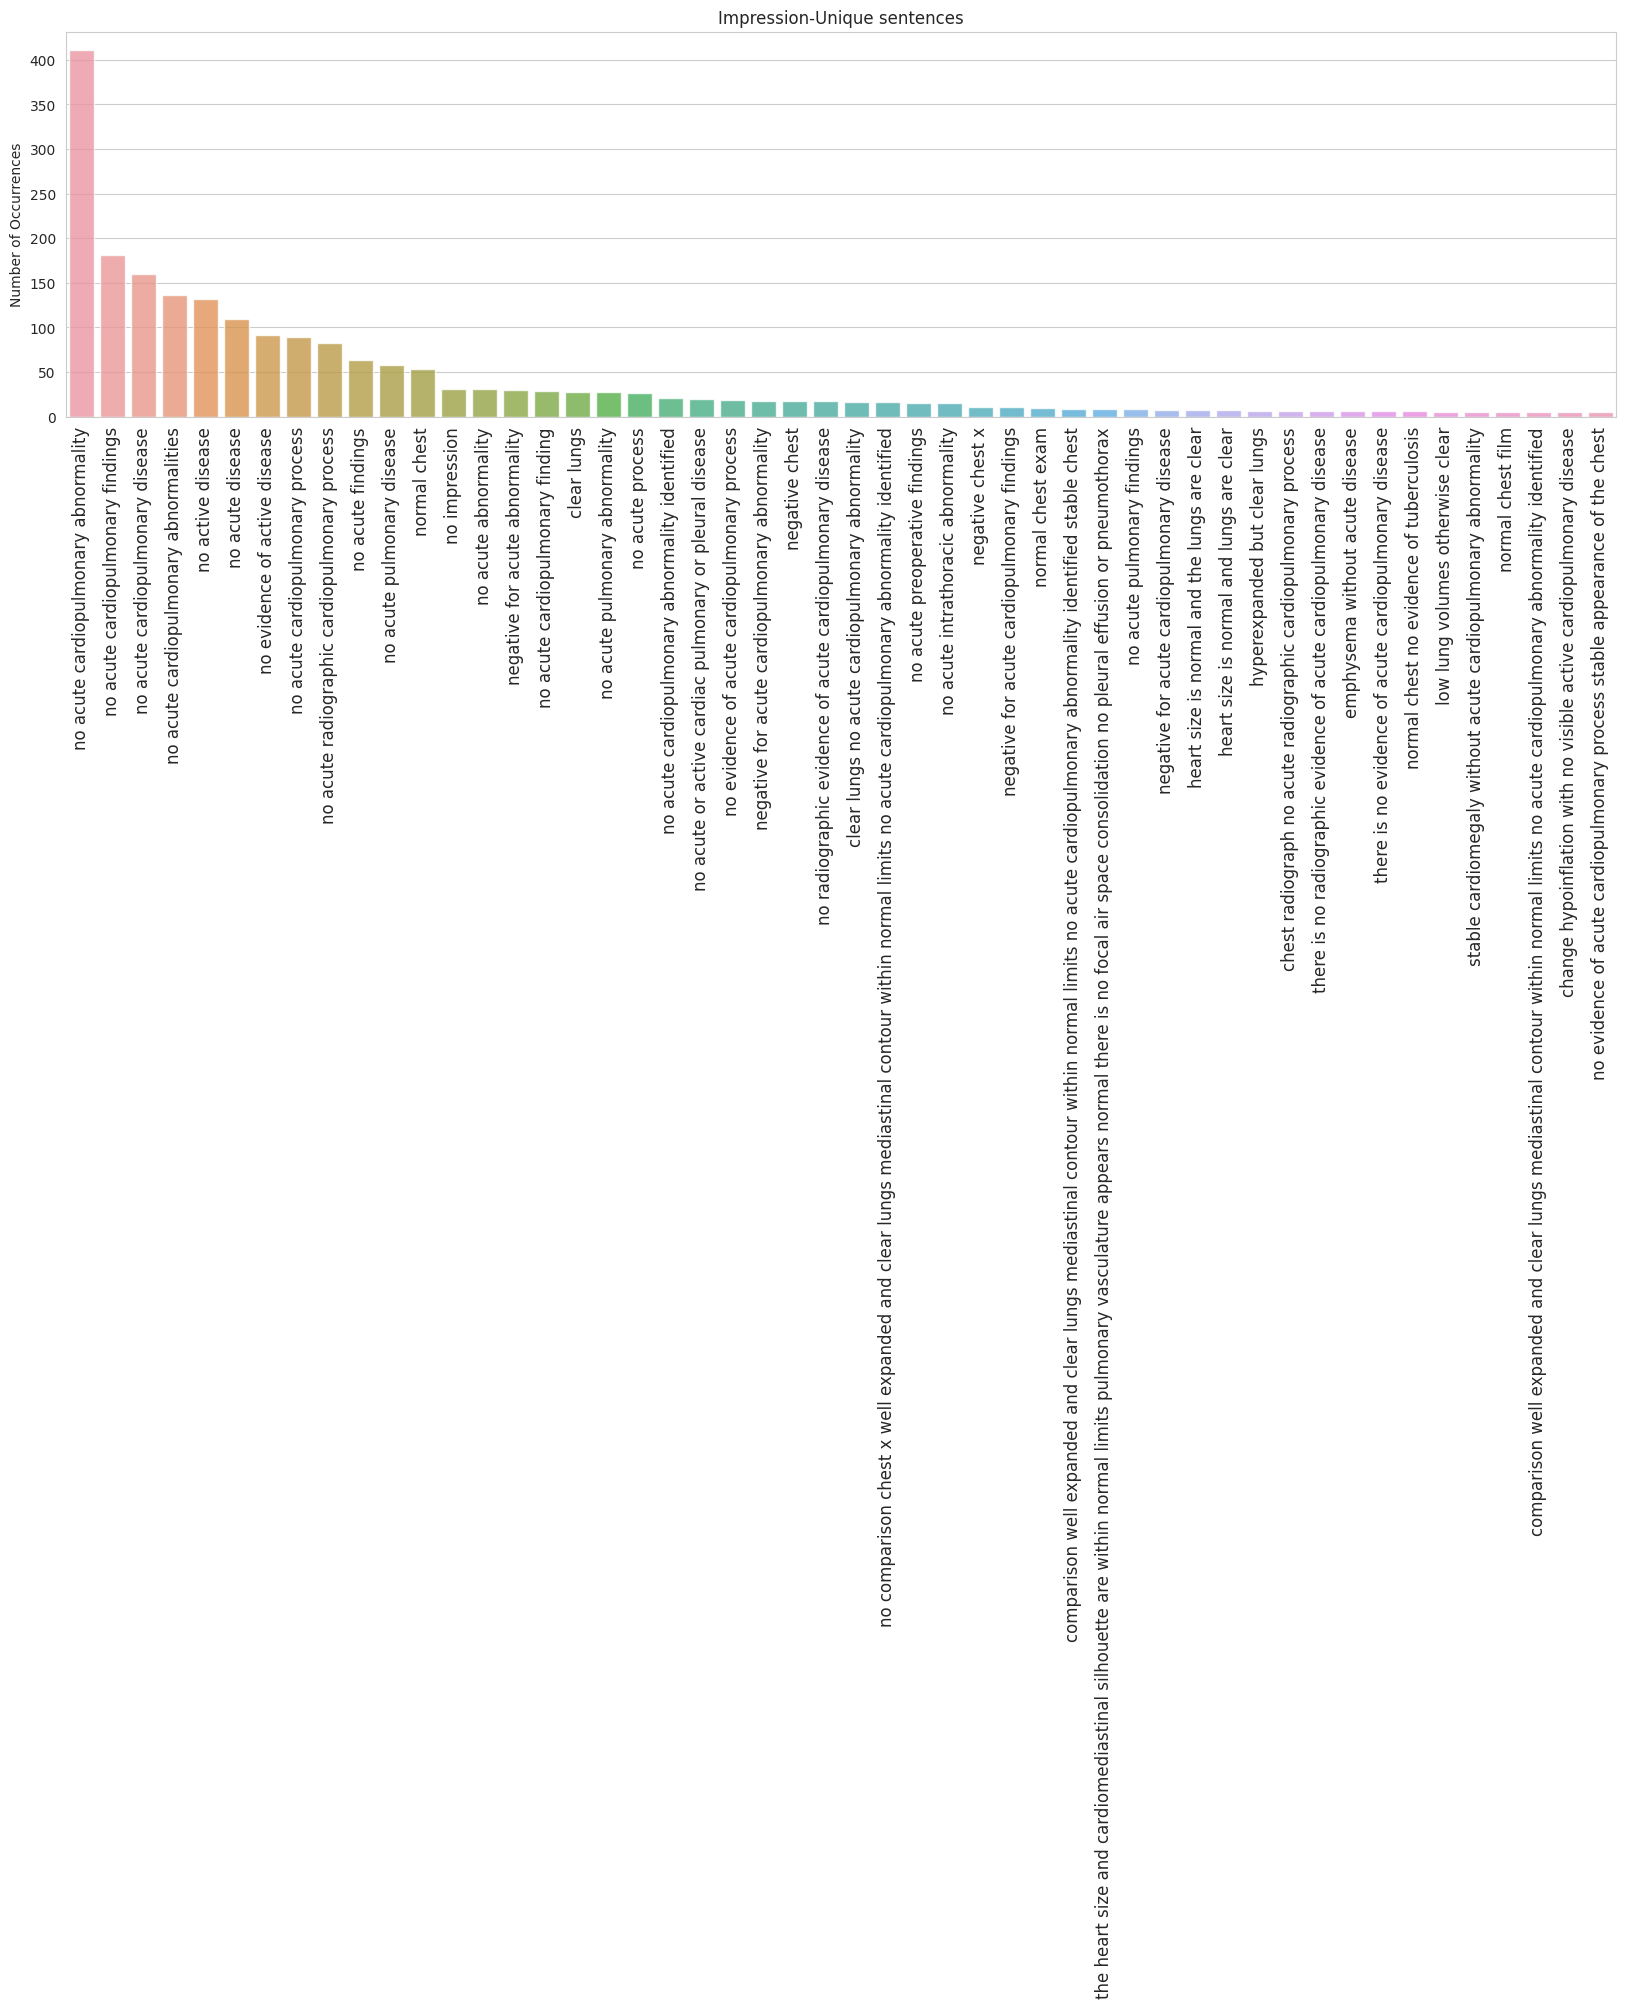

In [ ]:
#Plotting top 50 frequent sentences of Impression feature
sentences = dataframe['impression'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(x=sentences.index, y=sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("Impression-Unique sentences")
plt.show()

Word cloud on Impression feature : max 500 words

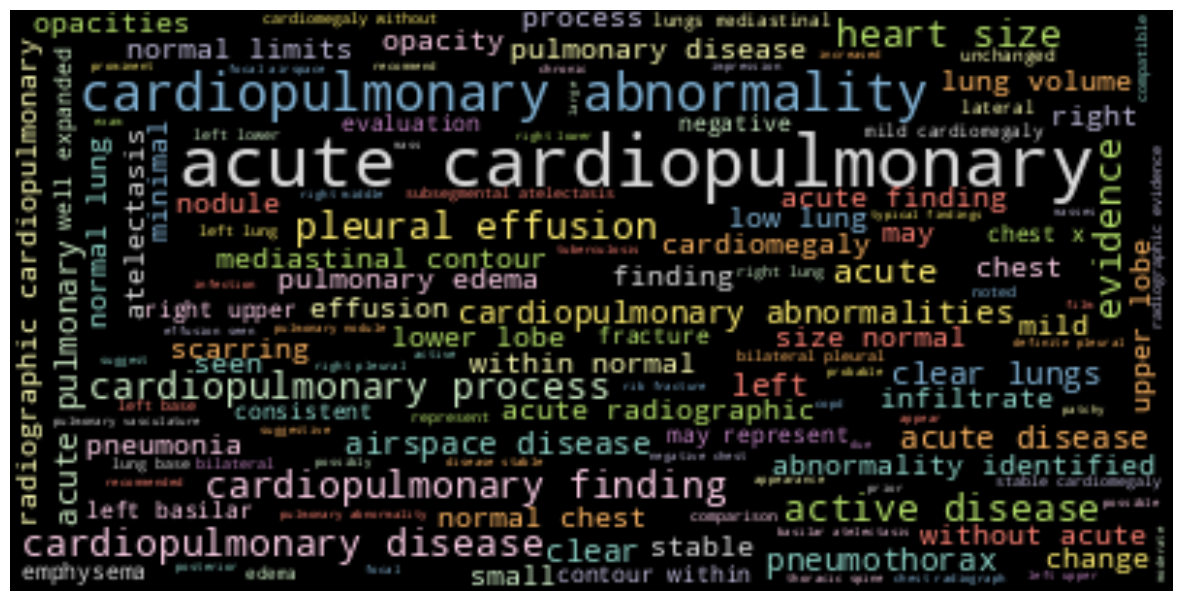

In [ ]:
wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(dataframe['impression'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

**Observations for Indication feature :**

* Top two most impression are 'no actue cardiopulmonary abnormality' and 'no actue cardiopulmonary findings' above 400 counts in feature.
* In indication feature, 50% data have less than 4 words per impression, it means only few impression have less words. 99% data have less than 39 words per impression. Only 1% data have legnth above 39.
* From wordcloud : actue cardiopulmonary, cardiopulmonary abnormality, disease acute, heart size are the highlighted words i.e. these are important words.

**Total Observations :**

* The dataset contains chest X-ray images and radiology text reports. Each image has been paired with four captions such as Impressions, Findings, Comparison and Indication that provide clear descriptions of the salient entities and events.. All the raw texts from xml files are parsed and created the dataset.

* Images are in different shapes. All the X-Ray images are human upper body particularly about Chest part.

* Each patient have multiple x-rays associated with them. The maximum number of images associated with a report can be 5 while the minimum is 0. The highest frequecy of being associated with a report are 2 images.

* Data is incomplete. Because all the features have few missing values except caption. We have to impute the missing values in data preprocessing step.

* In text features there are some unknown values like XXXX XXXXX these are replaced with empty string.

* We have total of 3955 records and Impression is our target variable.

* Most occurring words of diffrent features:
    > Indication: Chest pain

    > Findings: Pleural effusion

    > Impression: acute cardiopulmonary

* I created wordcloud, for 500 most frequent words of the feature. These are important words. Some of them are: acute, findings, disease, abnormality, high, right, impression, etc.

In [ ]:
dataframe

image_name  \
0     CXR2219_IM-0823-1001.png,CXR2219_IM-0823-2001.png   
1     CXR2607_IM-1097-3003.png,CXR2607_IM-1097-2002.png   
2     CXR2671_IM-1148-1001-0001.png,CXR2671_IM-1148-...   
3     CXR3203_IM-1513-2001.png,CXR3203_IM-1513-1001.png   
4     CXR2449_IM-0984-1001.png,CXR2449_IM-0984-2001.png   
...                                                 ...   
3950  CXR1282_IM-0188-2001.png,CXR1282_IM-0188-1001.png   
3951  CXR3798_IM-1911-2001.png,CXR3798_IM-1911-1001.png   
3952  CXR1443_IM-0286-1001.png,CXR1443_IM-0286-2001.png   
3953  CXR2934_IM-1337-1001.png,CXR2934_IM-1337-1002.png   
3954  CXR3679_IM-1831-1001.png,CXR3679_IM-1831-2001.png   

                                  image_caption                comparison  \
0                           view chest at hours                      none   
1                      ray chest pa and lateral     no comparison chest x   
2                                       chest x                       NaN   
3                      ray chest pa and lateral                      none   
4                                         chest                       NaN   
...                                         ...                       ...   
3950               ap and lateral chest x hours                   chest x   
3951  chest x and lateral performed on at hours  chest x single view from   
3952              chest pa and lateral views pm                      none   
3953                      chest frontal lateral             no comparison   
3954                    chest radiograph images                      none   

                               indication  \
0      and chest pain commissure breath x   
1                                yof with   
2                                weakness   
3                             and dyspnea   
4                                 dyspnea   
...                                   ...   
3950  arterial female shortness of breath   
3951                      male chest pain   
3952                              dyspnea   
3953                lb unintentional loss   
3954                           chest pain   

                                               findings  \
0                                           no findings   
1                                           no findings   
2                                           no findings   
3     cardiac and mediastinal contours are within no...   
4     the lungs are clear the cardiomediastinal silh...   
...                                                 ...   
3950  normal heart size and mediastinal contours pat...   
3951  the heart is normal in size the pulmonary vasc...   
3952  and lateral chest examination was obtained the...   
3953  the heart is normal in size the mediastinum is...   
3954  normal heart clear lungs no pneumothorax no pl...   

                                             impression  image_count  \
0     the heart size and cardiomediastinal silhouett...            2   
1     lungs appear hyperinflated this may be seconda...            2   
2     pa and lateral views were obtained again a chr...            2   
3                                     no acute findings            2   
4                                        negative chest            2   
...                                                 ...          ...   
3950  mild nonconsolidating right lower lobe airspac...            2   
3951                     right basilar airspace disease            2   
3952                         no acute pulmonary disease            2   
3953                                   no acute disease            2   
3954                                  normal chest exam            2   

      indication_count  findings_count  impression_count  
0                    6               2                33  
1                    2               2                25  
2                    1               2                39  
3                    2              16                 3  
4

In [ ]:
df_temp=dataframe.copy()

In [ ]:
def show_image_captions(df):
    '''This function prints the sample images and its other text features.
       Parameters :
       - df: dataframe
       - sample: Number of datapoints'''

    sampled_row = df
    images=[]
    for count, row in sampled_row.iterrows():
        imgs = row["image_name"].split(',')
        temp=[]
        for img in imgs:
            image= mpimg.imread("./xray_images/"+img)
            resized_image = cv2.resize(image, (256, 256))
            temp.append(resized_image)
        images.append(temp)
    df['images']=images
# dataframe=dataframe.sample(500)
df_temp = dataframe.iloc[:500]
show_image_captions(df_temp)
dataframe.head()

image_name  \
0  CXR2219_IM-0823-1001.png,CXR2219_IM-0823-2001.png   
1  CXR2607_IM-1097-3003.png,CXR2607_IM-1097-2002.png   
2  CXR2671_IM-1148-1001-0001.png,CXR2671_IM-1148-...   
3  CXR3203_IM-1513-2001.png,CXR3203_IM-1513-1001.png   
4  CXR2449_IM-0984-1001.png,CXR2449_IM-0984-2001.png   

              image_caption             comparison  \
0       view chest at hours                   none   
1  ray chest pa and lateral  no comparison chest x   
2                   chest x                    NaN   
3  ray chest pa and lateral                   none   
4                     chest                    NaN   

                           indication  \
0  and chest pain commissure breath x   
1                            yof with   
2                            weakness   
3                         and dyspnea   
4                             dyspnea   

                                            findings  \
0                                        no findings   
1                                        no findings   
2                                        no findings   
3  cardiac and mediastinal contours are within no...   
4  the lungs are clear the cardiomediastinal silh...   

                                          impression  image_count  \
0  the heart size and cardiomediastinal silhouett...            2   
1  lungs appear hyperinflated this may be seconda...            2   
2  pa and lateral views were obtained again a chr...            2   
3                                  no acute findings            2   
4                                     negative chest            2   

   indication_count  findings_count  impression_count  
0                 6               2                33  
1                 2               2                25  
2                 1               2                39  
3                 2              16                 3  
4                 1              28                 2

In [ ]:
print(len(df_temp))

500


In [ ]:
print((dataframe['images'].iloc[0][0].shape))

(256, 256, 3)


In [ ]:
X_train=[]
for i in df_temp['images']:
  X_train.append(i[0])

X_train=np.array(X_train)
X_train.shape

(500, 256, 256, 3)

In [ ]:
X_train = X_train.astype('float32') / 255.0

In [ ]:
import keras, keras.backend as K
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose
def ConvAutoEncoder(img_dim, encoded_size):
    #Encoder Part
    enc = keras.models.Sequential()
    enc.add(InputLayer(img_dim))
    enc.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling2D(pool_size=(2, 2)))
    enc.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling2D(pool_size=(2, 2)))
    enc.add(Flatten())
    enc.add(Dense(encoded_size))

    #Decoder Part
    dec = keras.models.Sequential()
    dec.add(InputLayer((encoded_size,)))
    dec.add(Dense(262144))
    dec.add(Reshape((64,64,64)))
    dec.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    dec.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))

    return enc, dec

encoder, decoder = ConvAutoEncoder(img_dim=(256,256,3), encoded_size=512)

In [ ]:
# encoder.load_weights("encoder.pth")
# decoder.load_weights("decoder.pth")

In [ ]:
encoder.summary()
decoder.summary()

In [ ]:
input = Input((256,256,3))
encoded = encoder(input)
decoded = decoder(encoded)

cae = keras.models.Model(inputs=input, outputs=decoded)
cae.compile(optimizer='adamax', loss='mean_squared_error')

In [ ]:
cae.fit(X_train, X_train, batch_size=16, epochs=50, verbose=1)

Epoch 1/50
32/32 [==============================] - 177s 5s/step - loss: 1.3048e-06
Epoch 2/50
32/32 [==============================] - 199s 6s/step - loss: 1.0261e-06
Epoch 3/50
32/32 [==============================] - 178s 6s/step - loss: 1.0084e-06
Epoch 4/50
32/32 [==============================] - 168s 5s/step - loss: 9.4609e-07
Epoch 5/50
32/32 [==============================] - 165s 5s/step - loss: 8.7792e-07
Epoch 6/50
32/32 [==============================] - 162s 5s/step - loss: 8.1680e-07
Epoch 7/50
32/32 [==============================] - 166s 5s/step - loss: 7.7635e-07
Epoch 8/50
32/32 [==============================] - 161s 5s/step - loss: 7.5870e-07
Epoch 9/50
32/32 [==============================] - 162s 5s/step - loss: 7.5734e-07
Epoch 10/50
32/32 [==============================] - 160s 5s/step - loss: 7.4473e-07
Epoch 11/50
32/32 [==============================] - 165s 5s/step - loss: 7.7764e-07
Epoch 12/50
32/32 [==============================] - 164s 5s/step - loss: 

In [ ]:
encoder.save_weights("encoder.pth")
decoder.save_weights("decoder.pth")

In [ ]:
dict_img_fin = {}
var2={}
matrix_img_vectors = []
for i in range(len(dataframe['images'])):
  images = dataframe[i,'images']
  for j in images:
    encoded_vector = encoder.predict(j)
    var2[encoded_vector]=j
    matrix_img_vectors.append(encoded_vector)
    dict_img_fin[encoded_vector] = dataframe[i,'findings']


In [ ]:
import imghdr
from numpy.linalg import norm
def check_input_type(user_input):
    try:
        with open(user_input, 'rb') as f:
            if imghdr.what(f) is not None:
                return 'Image'
    except FileNotFoundError:
        pass

    if isinstance(user_input, str):
        return 'Text'

    return 'Unknown'

user_input = input("Enter the file path or text: ")

input_type = check_input_type(user_input)

if input_type == 'Image':
  top10_encoded = []
  temp=[]
  image= mpimg.imread(user_input)
  resized_image = cv2.resize(image, (256, 256))
  temp.append(resized_image)
  encoded_query = encoder.predict(temp)
  dict_query = {}
  for i in matrix_img_vectors:
    A = np.array(i)
    B = np.array(encoded_query)
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    dict_query[A] = cosine
  keys = list(dict_query.keys())
  values = list(dict_query.values())
  sorted_value_index = np.argsort(values)[::-1]
  dict_query = {keys[i]: values[i] for i in sorted_value_index}
  c=0
  for keys in dict_query.keys():
    print(key)
    print(dict_img_fin[key])
    c += 1
    if c==10:
      break

else :
  c=0
  line=user_input
  for key in dict2.keys():
      if line.find(key):
        # c+=1
        line.replace(key,dict2[key])
  user_input=line
  for i in vocabulary:
    temp1=[]
    words = user_input.split(" ")
    count=0
    for k in words:
      if k == i:
        count+=1
    if count!=0:
      temp1.append((1+math.log2(count))*math.log2(1+(max_ni/doc_freq[i])))
    else:
      temp1.append(0)
    dict_query = {}
    for j in range(matrix_inv_freq_max.shape[1]):
      B = np.array(matrix_inv_freq_max[ :,j])
      A = temp1
      cosine = np.dot(A,B)/(norm(A)*norm(B))
      dict_query[A] = cosine
  keys = list(dict_query.keys())
  values = list(dict_query.values())
  sorted_value_index = np.argsort(values)[::-1]
  dict_query = {keys[i]: values[i] for i in sorted_value_index}
  c=0
  for keys in dict_query.keys():
    print(key)
    c += 1
    if c==10:
      break

In [ ]:
# dataframe['images'].iloc[0][0].shape
img=np.array([dataframe['images'].iloc[0][0]])
img.shape

encoded_vector = encoder.predict(img)
encoded_vector.shape

1/1 [==============================] - 0s 211ms/step


(1, 512)

In [ ]:
!git clone https://github.com/rlrocha/bag-of-visual-words.git

Cloning into 'bag-of-visual-words'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 127 (delta 9), reused 119 (delta 4), pack-reused 0
Receiving objects: 100% (127/127), 3.08 MiB | 24.05 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
import sys

sys.path.append('./bag-of-visual-words/src')
from elm import ELMClassifier

In [ ]:
from sklearn.pipeline import Pipeline
from bovw import BagOfVisualWords

param = (100, 88, 10)

pipe = Pipeline([('BOVW', BagOfVisualWords(n_clusters=param[0])),
                     ('Classifier', ELMClassifier(L=param[1], random_state=param[2]))])

Keypoint descriptors shape: (53, 128)


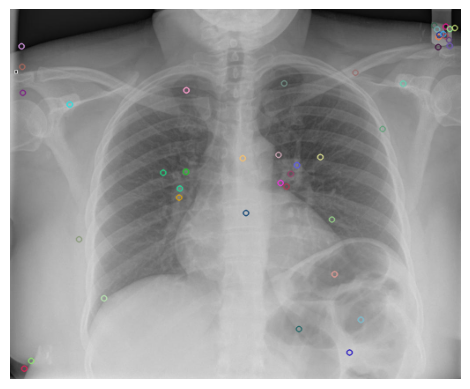

In [ ]:
from bovw import BagOfVisualWords
image = cv2.imread('./xray_images/CXR2153_IM-0773-1001.png', 0)

sift = cv2.SIFT_create()

kp, des = sift.detectAndCompute(image, None)

img = cv2.drawKeypoints(image, kp, image)

print(f'Keypoint descriptors shape: {des.shape}')

plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
pipe.fit(Xtrain, ytrain)

In [ ]:
# Extract the keypoints descriptors of the current image
_, des = sift.detectAndCompute(image, None)

# Define the feature vector of the current image
feature_vector = np.zeros(bovw.bag.n_clusters, dtype=np.float32)

# Uses the BoVW to predict the visual words of each keypoint descriptors of the current image
word_vector = bovw.bag.predict(np.asarray(des, dtype=float))

# For each unique visual word
for word in np.unique(word_vector):
    res = list(word_vector).count(word) # Count the number of word in word_vector
    feature_vector[word] = res # Increments histogram for that word

# Normalizes the current histogram
feature_vector_normalized = np.zeros(bovw.bag.n_clusters, dtype=np.float32)
cv2.normalize(feature_vector, feature_vector_normalized, norm_type=cv2.NORM_L2)

_, axes = plt.subplots(1,2, figsize=(8,4), dpi=300)
plt.tight_layout()

feature_vectors = [feature_vector, feature_vector_normalized]
color_list = ['blue', 'red']
title_list = ['Feature vector histogram', 'Feature vector histogram (Normalized)']

for i in range(len(axes)):
    axes[i].bar(np.arange(1, len(feature_vectors[i])+1), feature_vectors[i], color=color_list[i])
    axes[i].set_xlabel('Visual words')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(title_list[i])
    axes[i].grid()

plt.subplots_adjust(right=1.5)

plt.show()